# Tutorial of Advanced Communications Engineering - Session 0

Welcome to the ACE Tutorial! Here you will find code examples that illustrate the concepts presented in the lectures. This collection of Jupyter Notebooks also serve as an introduction on how to simulate the physical layer of a communications system, an important tool for a communications engineer.

We start in Session 0 with an example that applies the main concepts reviewed during the first lecture, which include modulation, noise, demodulation, etc. The following code implements an end-to-end transmission chain, where firstly the information symbols are generated as a random sequence, and then modulated, transmitted through a noisy channel, and finally demodulated and compared with the transmitted symbols at the receiver.

### Part 1) QAM modulation and AWGNC Channel

In [1]:
# We start with importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace, expon

Next we follow by defining the _constellation_ we want to use. Our examples will focus on QAM, but you can implement other modulation formats yourself (e.g. PSK, PAM, etc.). At this point, we won't consider _how_ the information bits are mapped to the IQ symbols.

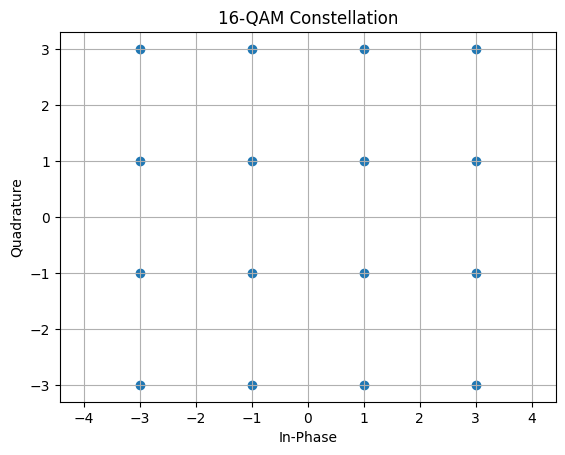

In [2]:
n_symbols = 16                          # Number of symbols in the constellation
n_rows = int(np.sqrt(n_symbols))        # Number of rows in the constellation
constellation = np.array([n_rows - 1 - 2 * i + 1j * (n_rows - 1 - 2 * j) for i in range(n_rows) for j in range(n_rows)])

# Helper function to visualize the constellation
def visualize_constellation(constellation, title):
    plt.scatter(constellation.real, constellation.imag)
    plt.title(title)
    plt.xlabel('In-Phase')
    plt.ylabel('Quadrature')
    plt.grid()
    plt.axis('equal')
    plt.show()
    
visualize_constellation(constellation, f'{n_symbols}-QAM Constellation')

Notice however that the above constellation is not normalized to have _unitary symbol energy_. Normalization is required so that the comparison between the different modulation formats is fair.

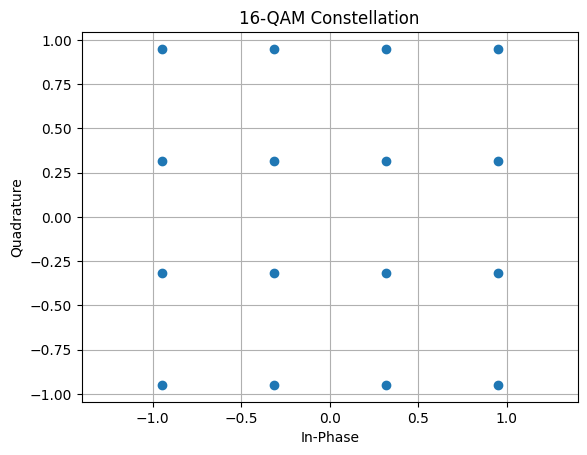

In [3]:
# Here we already observe one advantage of using numpy arrays: we can easily perform mathematical operations on all elements of the array at once
constellation = constellation / np.sqrt(np.mean(np.abs(constellation) ** 2))  # Normalization to unitary symbol energy
visualize_constellation(constellation, f'{n_symbols}-QAM Constellation')

Now we can generate the symbols _indexes_ that will be transmitted. These are random integers sampled uniformly.

In [4]:
symbols_idx = np.random.randint(0, n_symbols, size=1000)  # Generate random symbol indexes
transmitted_symbols = constellation[symbols_idx]          # Map indexes to constellation symbols

During the lecture, _linear_ modulation was introduced: $$S(t) = \sum_{n=0}^{\infty} A_n g(t - nT).$$

We then have to choose a _pulse shape_ $g(t)$ to use. Here we chose the root-raised-cosine filter, a choice that will become clearer in the next chapters. The expression can be found [in this Wikipedia page](https://en.wikipedia.org/wiki/Root-raised-cosine_filter). Can you implement it yourself?

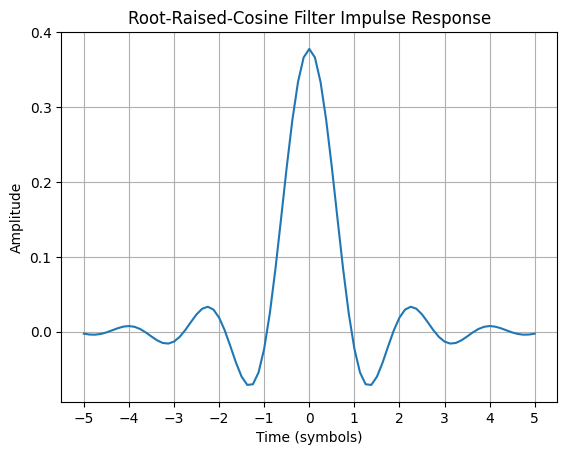

In [5]:
def get_rrc_ir(beta, span, sps):
    """Generate Root-Raised-Cosine (RRC) filter impulse response."""
    N = span * sps + 1  # Filter length (centered at 0)
    t = np.linspace(-span / 2, span / 2, N)
    # Avoid division by zero
    singularity_points = np.logical_or(t == 0, np.abs(t) == 1 / (4 * beta))
    h = np.zeros_like(t)
    h[np.logical_not(singularity_points)] = (np.sin(np.pi * t[np.logical_not(singularity_points)] * (1 - beta)) + 4 * beta * t[np.logical_not(singularity_points)] * np.cos(np.pi * t[np.logical_not(singularity_points)] * (1 + beta))) / (np.pi * t[np.logical_not(singularity_points)] * (1 - (4 * beta * t[np.logical_not(singularity_points)]) ** 2))
    # Populate with correct values at singularities
    h[t == 0] = 1.0 - beta + (4 * beta / np.pi)
    h[np.abs(t) == 1 / (4 * beta)] = (beta / np.sqrt(2)) * ((1 + 2 / np.pi) * (np.sin(np.pi / (4 * beta))) + (1 - 2 / np.pi) * (np.cos(np.pi / (4 * beta))))
    return h / np.sqrt(np.sum(h ** 2))  # Normalize filter energy

# Filter parameters
beta = 0.25     # Roll-off factor
span = 10       # Filter span in symbols
sps = 8         # Samples per symbol

rrc_ir = get_rrc_ir(beta, span, sps)
plt.plot(np.linspace(-span / 2, span / 2, len(rrc_ir)), rrc_ir)
plt.xlabel('Time (symbols)')
plt.ylabel('Amplitude')
plt.title('Root-Raised-Cosine Filter Impulse Response')
plt.xticks(np.arange(-span / 2, span / 2 + 1, 1))
plt.grid()
plt.show()

How can we then shift and modulate this waveform? Easy: convolution!
$$
\begin{align*}
S(t) &= \left(\sum_{n=0}^{\infty} A_n \delta (t - nT)\right) * g(t) \\
&= \sum_{n=0}^{\infty} A_n \delta (t - nT) * g(t) \\
&= \sum_{n=0}^{\infty} A_n g(t - nT).
\end{align*}
$$

Therefore, we proceed with the simulated version of $$\left(\sum_{n=0}^{\infty} A_n \delta (t - nT)\right).$$

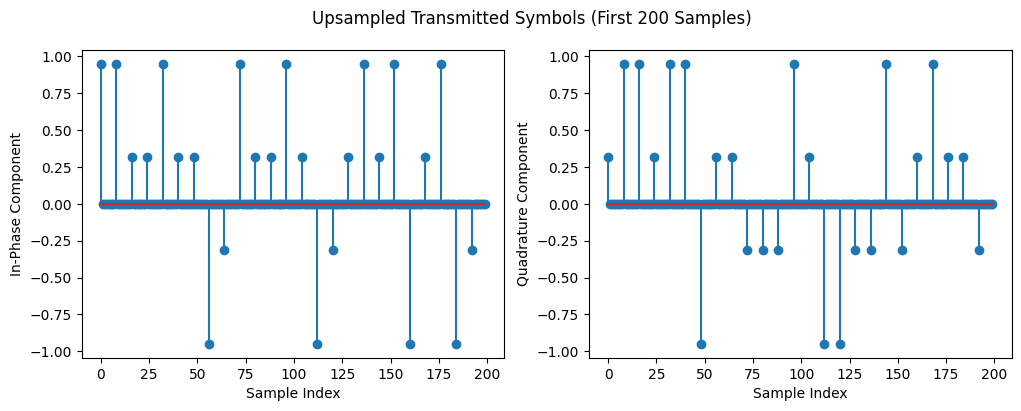

In [6]:
upsampled_symbols = np.zeros(len(transmitted_symbols) * sps, dtype=complex)
upsampled_symbols[::sps] = transmitted_symbols  # Insert symbols at every sps-th position

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].stem(np.arange(200), upsampled_symbols.real[:200], label='In-Phase')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('In-Phase Component')
ax[1].stem(np.arange(200), upsampled_symbols.imag[:200], label='Quadrature')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Quadrature Component')
fig.suptitle('Upsampled Transmitted Symbols (First 200 Samples)')
fig.show()

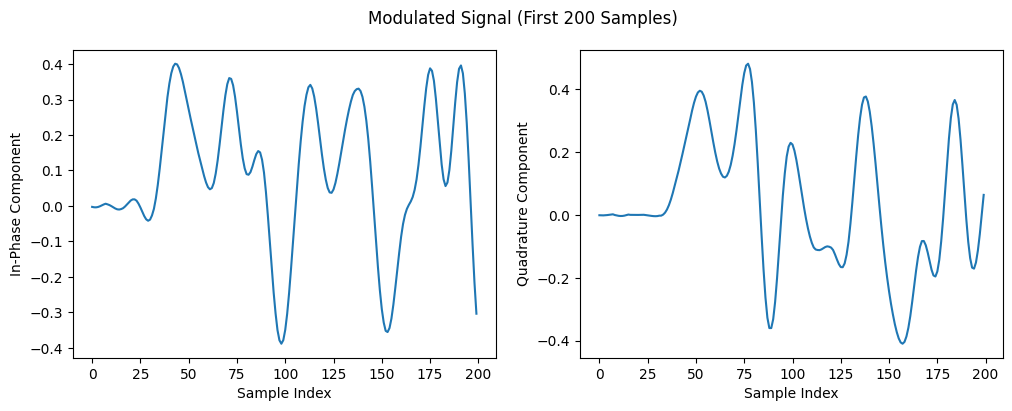

In [7]:
 # Convolve upsampled symbols with RRC filter to get the modulated signal
modulated_signal = np.convolve(upsampled_symbols, rrc_ir, mode='full')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(200), modulated_signal.real[:200], label='In-Phase')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('In-Phase Component')
ax[1].plot(np.arange(200), modulated_signal.imag[:200], label='Quadrature')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Quadrature Component')
fig.suptitle('Modulated Signal (First 200 Samples)')
plt.show()

We add noise to the signal:

In [8]:
# Choose a SNR value
es_n0_dB = 20  # Signal-to-Noise Ratio in dB
es_n0 = 10 ** (es_n0_dB / 10)

We have already fixed the symbol energy to one, and also normalizing the energy of the pulse shape $g(t)$ guarantees that the received signal after matched filtering (correlation) will also have power equal to one.

In [9]:
# Therefore,
n0 = 1 / es_n0  # Since symbol energy is normalized to 1

# Add noise to the modulated signal
noise = np.sqrt(n0 / 2) * (np.random.randn(len(modulated_signal)) + 1j * np.random.randn(len(modulated_signal)))
received_signal = modulated_signal + noise

Important to notice: as discussed in the lecture, the noise is _circular_, meaning that real and imaginary parts are generated independently of each other. Furthermore, the noise is _white_, meaning that different time samples are _uncorrelated_.

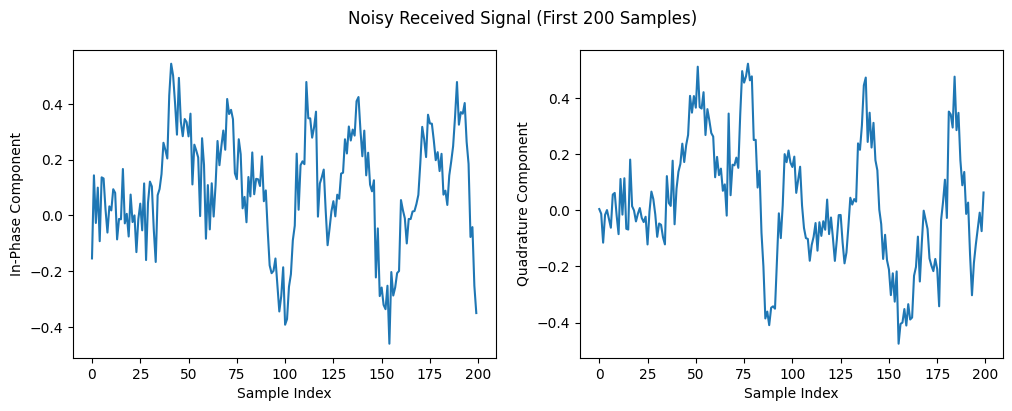

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(200), received_signal.real[:200], label='In-Phase with Noise')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('In-Phase Component')
ax[1].plot(np.arange(200), received_signal.imag[:200], label='Quadrature with Noise')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Quadrature Component')
fig.suptitle('Noisy Received Signal (First 200 Samples)')
plt.show()

All that is left now is to implement the matched filter (MF) and then detect the symbols!

In [11]:
demodulated_signal = np.convolve(received_signal, rrc_ir, mode='full')

We also have to compensate for delays introduced during the filtering process. Observe the following plot:

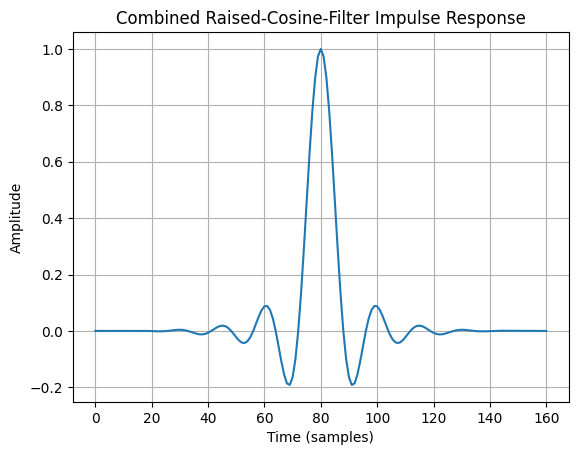

Combined filter length: 161 samples


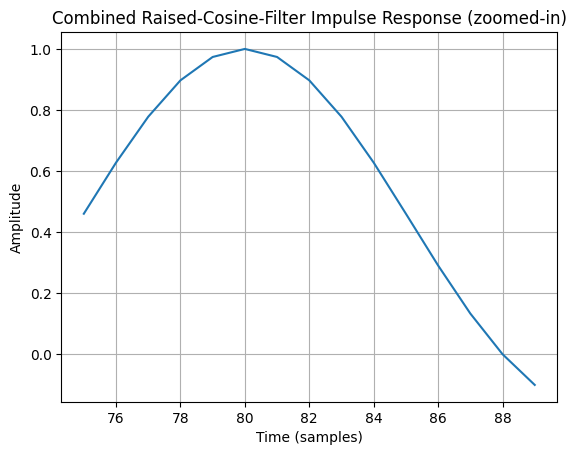

In [12]:
rc_ir = np.convolve(rrc_ir, rrc_ir, mode='full')
plt.plot(np.arange(len(rc_ir)), rc_ir)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Combined Raised-Cosine-Filter Impulse Response')
plt.grid()
plt.show()
print(f'Combined filter length: {len(rc_ir)} samples')

plt.plot(np.arange(75, 90), rc_ir[75:90])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Combined Raised-Cosine-Filter Impulse Response (zoomed-in)')
plt.grid()
plt.show()

By computing $g(t) * g(t)$, we observe that the peak of the impulse response has a delay of 80 samples! By zooming-in we can perform the sanity check that the peak of $g(t) * g(t)$ is 1, and that at the sps-th sample after the peak the response is zero, and therefore no inter-symbol interference (ISI) is observed.

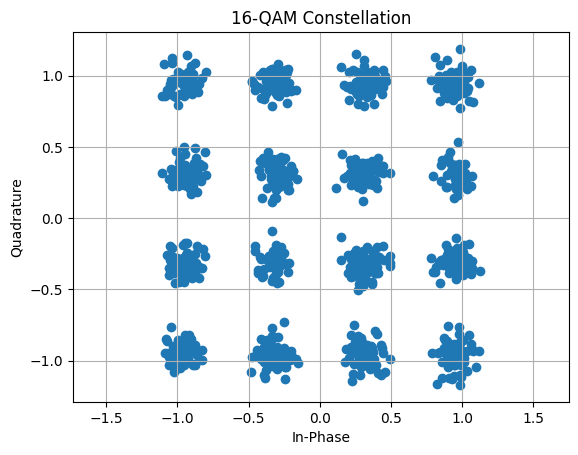

In [13]:
# Here we introduce a parameter that will be used afterwards
time_offset = 0

# Correct for delay introduced by filtering
filter_delay = (len(rrc_ir) - 1)  # Delay introduced by two RRC filters
start_idx = filter_delay + time_offset
end_idx = start_idx + len(transmitted_symbols) * sps
received_symbols = demodulated_signal[start_idx:end_idx:sps]

visualize_constellation(received_symbols, f'{n_symbols}-QAM Constellation')

We can perform a sanity check on the signal power:

In [14]:
received_power = np.mean(np.abs(received_symbols) ** 2)
print(f'Received Signal Power: {received_power:.4f}')
print(f'Expected Signal Power: {1.0 + n0:.4f}')

Received Signal Power: 1.0156
Expected Signal Power: 1.0100


Are we able to detect the symbols correctly using the MAP rule for AWGNC? Remember: $$\hat{m}_{\text{MAP}}[k] = \underset{m}{\text{argmax}} \| r[k] - s_m \|^2$$

In [15]:
# Distance array:
distance_array = np.abs(received_symbols[:, np.newaxis] - constellation[np.newaxis, :]) ** 2    # Each column corresponds to a constellation point
estimated_symbols_idx = np.argmin(distance_array, axis=1)

# Calculate Symbol Error Rate (SER)
n_errors = np.sum(estimated_symbols_idx != symbols_idx)
ser = n_errors / len(symbols_idx)
print(f'Symbol Error Rate (SER): {ser:.4f}')

Symbol Error Rate (SER): 0.0000


***
#### <font color='green'>Exercise</font>
As follow-up work for this section, try to explore the following:
- Beginner:
    - Implement other constellations;
    - Change the value of the _roll-off_ factor `beta` in the simulation;
    - Change the $E_s/N_0$ value in the simulation;
    - The parameter _time offset_ defined earlier can be used to simulate a mismatch of the sampling time and the symbol time. How does the scatter plot look like if `time_offset` is set to something different than zero?

- Advanced:
    - Can you implement other pulse shapes?
    - Can you experiment with different kinds of noise?
    - How would you modify this simulation to determine the SER for a range of $E_s/N_0$ values? How can you decrease the variance of the SER estimation?
***

### Part 2) Illustration of a Bandpass Signal

Now, we simplify the system above to illustrate how a bandpass signal looks like.

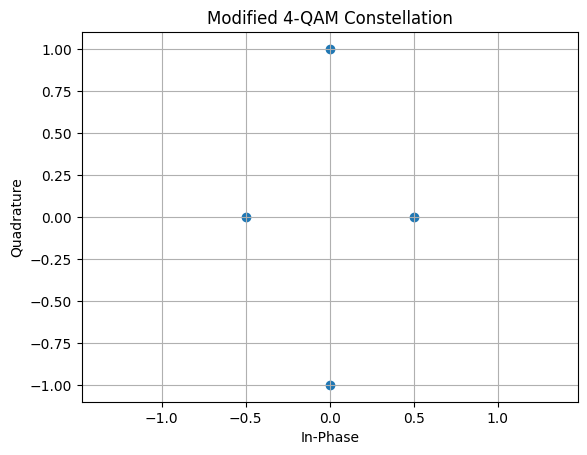

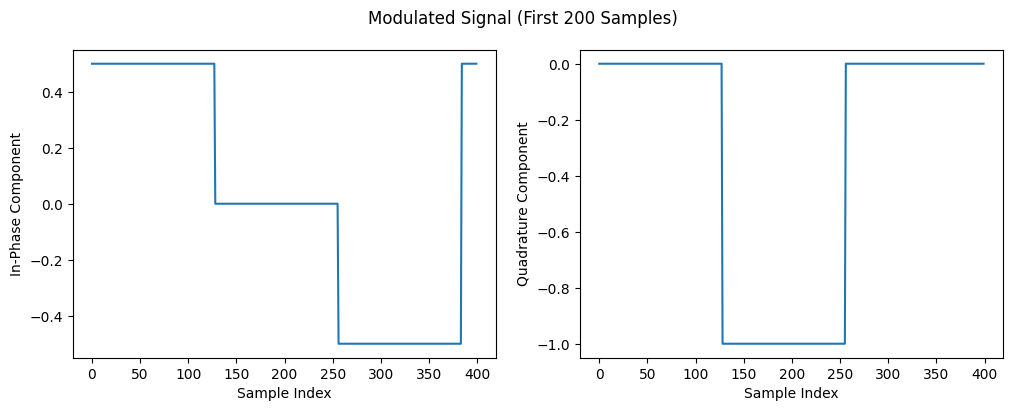

In [16]:
# We redefine the constellation for visualization purposes, and also increase the sps
n_symbols = 4
sps = 128
constellation = np.array([-0.5, 0.5, -1j, 1j])
visualize_constellation(constellation, f"Modified 4-QAM Constellation")

# We start just as before
symbols_idx = np.random.randint(0, n_symbols, size=1000)  # Generate random symbol indexes
transmitted_symbols = constellation[symbols_idx]          # Map indexes to constellation symbols

# Now we use a rectangular pulse shaping filter
modulated_signal = np.repeat(transmitted_symbols, sps)  # Rectangular pulse shaping

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(400), modulated_signal.real[:400], label='In-Phase')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('In-Phase Component')
ax[1].plot(np.arange(400), modulated_signal.imag[:400], label='Quadrature')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Quadrature Component')
fig.suptitle('Modulated Signal (First 200 Samples)')
plt.show()

Time to get the bandpass signal! We choose a frequency that is not too high w.r.t. the symbol rate for illustration purposes.

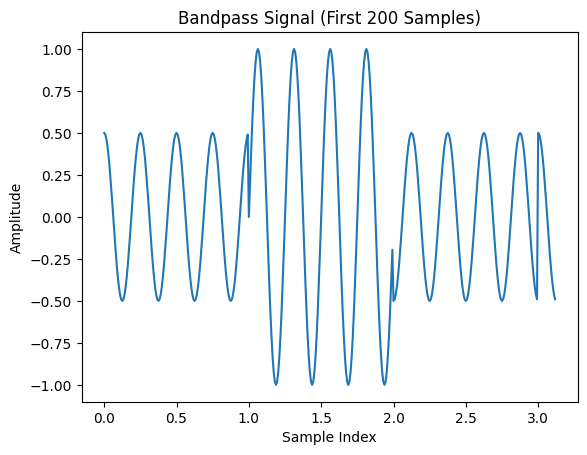

In [17]:
# Here, time is normalized to the symbol period, so t = 1 => 1 symbol period
t = np.arange(len(modulated_signal)) / sps
freq = 4  # Frequency in 1 / T
carrier = np.exp(2 * np.pi * 1j * freq * t)

# Modulate the signal to bandpass
bandpass_signal = (modulated_signal * carrier).real

plt.plot(t[:400], bandpass_signal[:400], label='Bandpass Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Bandpass Signal (First 200 Samples)')
plt.show()

***
#### <font color='green'>Exercise</font>
Here you can try out the following:
- Test other constellations;
- Test other values for the normalized frequency `freq`. Try increasing it to 100. What is the maximum value we can set for this value, if we want to still be able to visualize correctly? **(Hint: think about the sps and the Nyquist rate)**.
***

### Part 3) MAP for non-Gaussian Noise

As emphasized in the lecture, the minimum-distance rule for detection is only equivalent to the MAP rule for a few cases. Depending on the nature of the noise, the decision rule is different, and here we illustrate this.

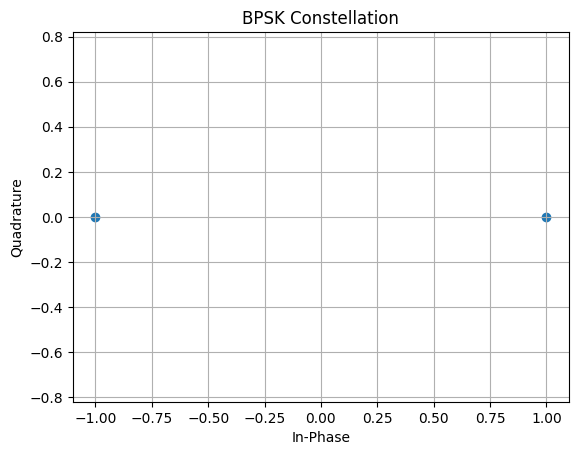

In [22]:
# We start with defining a simple constellation and parameters
n_symbols = 2
constellation = np.array([-1., 1.])
visualize_constellation(constellation, "BPSK Constellation")

es_n0_dB = 2  # Signal-to-Noise Ratio in dB
es_n0 = 10 ** (es_n0_dB / 10)
n0 = 1 / es_n0  # Since symbol energy is normalized to 1

Assuming that the bits are equally likely (i.e. $P(b=0) = P(b=1) = 1/2$), the MAP rule is equivalent to the ML rule. We then plot the likelihoods $f(r \mid s=-1)$ and $f(r \mid s=1)$ for different noise distributions:

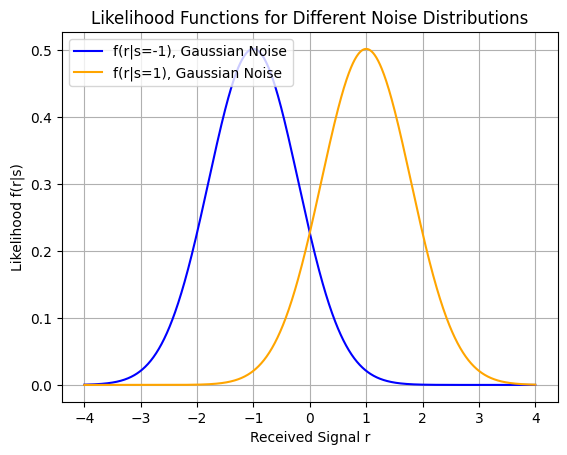

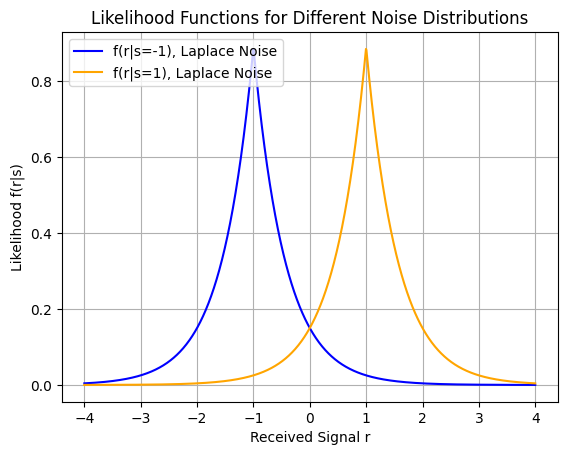

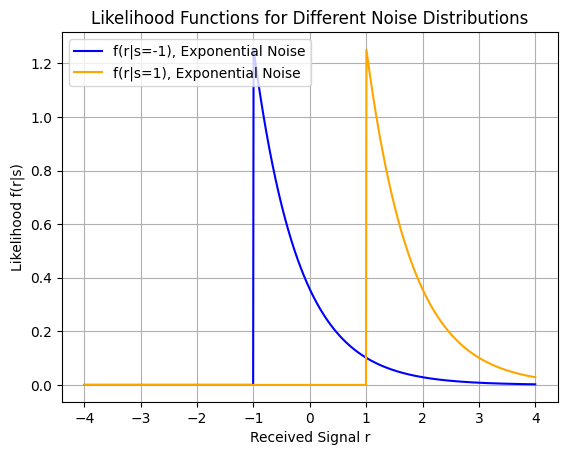

In [23]:
x = np.linspace(-4, 4, 1000)
# Gaussian noise
sigma = np.sqrt(n0)
likelihood_gaussian_s0 = norm.pdf(x, loc=-1, scale=sigma)
likelihood_gaussian_s1 = norm.pdf(x, loc=1, scale=sigma)
# Laplace noise
sigma_l = sigma / np.sqrt(2)
likelihood_laplace_s0 = laplace.pdf(x, loc=-1, scale=sigma_l)
likelihood_laplace_s1 = laplace.pdf(x, loc=1, scale=sigma_l)
# Exponential noise
likelihood_expon_s0 = expon.pdf(x, loc=-1, scale=sigma)
likelihood_expon_s1 = expon.pdf(x, loc=1, scale=sigma)

plt.figure()
plt.plot(x, likelihood_gaussian_s0, label='f(r|s=-1), Gaussian Noise', color='blue')
plt.plot(x, likelihood_gaussian_s1, label='f(r|s=1), Gaussian Noise', color='orange')
plt.xlabel('Received Signal r')
plt.ylabel('Likelihood f(r|s)')
plt.title('Likelihood Functions for Different Noise Distributions')
plt.legend(loc='upper left')
plt.grid()
plt.figure()
plt.plot(x, likelihood_laplace_s0, label='f(r|s=-1), Laplace Noise', color='blue')
plt.plot(x, likelihood_laplace_s1, label='f(r|s=1), Laplace Noise', color='orange')
plt.xlabel('Received Signal r')
plt.ylabel('Likelihood f(r|s)')
plt.title('Likelihood Functions for Different Noise Distributions')
plt.legend(loc='upper left')
plt.grid()
plt.show()
plt.figure()
plt.plot(x, likelihood_expon_s0, label='f(r|s=-1), Exponential Noise', color='blue')
plt.plot(x, likelihood_expon_s1, label='f(r|s=1), Exponential Noise', color='orange')
plt.xlabel('Received Signal r')
plt.ylabel('Likelihood f(r|s)')
plt.title('Likelihood Functions for Different Noise Distributions')
plt.legend(loc='upper left')
plt.grid()

We see that for the distributions that are symmetric around the mean the decision regions remain the same, that is, $f(r \mid s=-1) > f(r \mid s=1)$ for $r < 0$. However, for the exponential distribution, the decision boundary is no longer at $r=0$.
***
#### <font color='green'>Exercise</font>
- Where is the new decision threshold? Can you compute the theoretical average symbol error probability for this case?
***

Now, for skewed priors where $P(b=0) \neq P(b=1)$, the ML rule is no longer equivalent to the MAP rule. In the following, we let $P(b=0)=0.3$ and $P(b=1)=0.7$ and we use AWGN. Furthermore, we use Bayes' theorem to obtain $P(s=\pm 1 \mid r)$:
$$
P(s = \pm 1 \mid r) = \frac{P(s=\pm 1) f(r \mid s=\pm 1)}{P(s=1) f(r \mid s=1) + P(s=-1) f(r \mid s=-1)}
$$


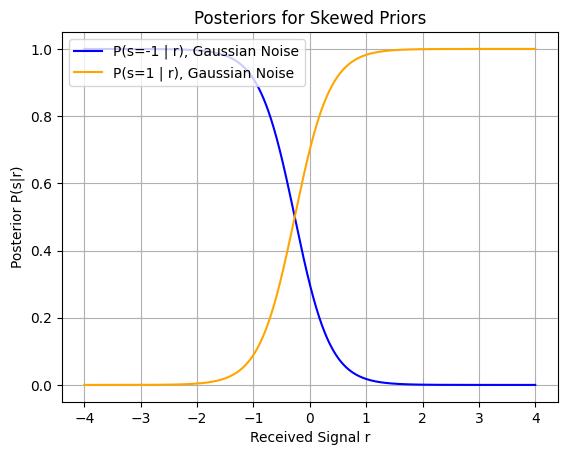

In [24]:
posterior_gaussian_s0 = likelihood_gaussian_s0 * 0.3 / (likelihood_gaussian_s0 * 0.3 + likelihood_gaussian_s1 * 0.7)
posterior_gaussian_s1 = likelihood_gaussian_s1 * 0.7 / (likelihood_gaussian_s0 * 0.3 + likelihood_gaussian_s1 * 0.7)

plt.figure()
plt.plot(x, posterior_gaussian_s0, label='P(s=-1 | r), Gaussian Noise', color='blue')
plt.plot(x, posterior_gaussian_s1, label='P(s=1 | r), Gaussian Noise', color='orange')
plt.xlabel('Received Signal r')
plt.ylabel('Posterior P(s|r)')
plt.title('Posteriors for Skewed Priors')
plt.legend(loc='upper left')
plt.grid()

Symbol Error Rate (SER) without optimal decision rule: 0.1003
Optimal decision threshold: -0.2603
Symbol Error Rate (SER) with optimal decision rule: 0.0883


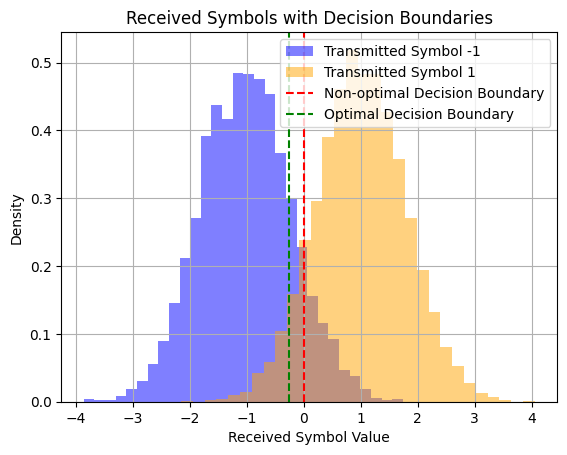

In [27]:
symbols_idx = (np.random.rand(10000) < 0.7).astype(int)   # Generate random symbol indexes
transmitted_symbols = constellation[symbols_idx]          # Map indexes to constellation symbols

# Add AWGN noise to the transmitted symbols
noise = np.sqrt(n0) * np.random.randn(len(transmitted_symbols))
received_symbols = transmitted_symbols + noise

# Decision rule without considering the shift in the distribution
estimated_symbols_idx_non_opt = (received_symbols >= 0).astype(int)
# Calculate Symbol Error Rate (SER) for non-optimal decision rule
n_errors_non_opt = np.sum(estimated_symbols_idx_non_opt != symbols_idx)
ser_non_opt = n_errors_non_opt / len(symbols_idx)
print(f'Symbol Error Rate (SER) without optimal decision rule: {ser_non_opt:.4f}')

# Optimal decision rule considering the shift in the distribution
threshold = x[np.nonzero(posterior_gaussian_s1 - posterior_gaussian_s0 > 0)[0][0]]
print(f'Optimal decision threshold: {threshold:.4f}')
estimated_symbols_idx_opt = (received_symbols >= threshold).astype(int)
# Calculate Symbol Error Rate (SER) for optimal decision rule
n_errors_opt = np.sum(estimated_symbols_idx_opt != symbols_idx)
ser_opt = n_errors_opt / len(symbols_idx)
print(f'Symbol Error Rate (SER) with optimal decision rule: {ser_opt:.4f}')

# Plotting the received symbols and decision boundaries
plt.figure()
plt.hist(received_symbols[symbols_idx == 0], bins=30, alpha=0.5, label='Transmitted Symbol -1', color='blue', density=True)
plt.hist(received_symbols[symbols_idx == 1], bins=30, alpha=0.5, label='Transmitted Symbol 1', color='orange', density=True)
plt.axvline(x=0, color='red', linestyle='--', label='Non-optimal Decision Boundary')
plt.axvline(x=threshold, color='green', linestyle='--', label='Optimal Decision Boundary')
plt.xlabel('Received Symbol Value')
plt.ylabel('Density')
plt.title('Received Symbols with Decision Boundaries')
plt.legend()
plt.grid()
plt.show()